# Understanding snowpack evolution using Sentinel‑1 SAR
This project investigates the seasonal evolution of snowpack and surface conditions at Hubbard Brook using Sentinel‑1 SAR backscatter data and in‑situ observations.  

The main motivation is that seasonal snow controls water storage, runoff timing, soil freeze–thaw, and land–atmosphere energy exchange, but it is still difficult to characterize snowpack conditions with sparse ground measurements.  
Sentinel‑1 SAR offers frequent, cloud‑independent observations that are sensitive to snow metamorphism, liquid water content, and melt–freeze cycles.  
Here, I focus on the shallow, wet, and highly transient snowpacks of the northeastern U.S., which are quite different from the deep alpine snowpacks that most previous studies have considered.

![SAR_tile](SAR_tile.png) 

# Import the main Python libraries

In [2]:
import os
import re
import glob
import numpy as np
import pandas as pd
import rasterio #read and handle the Sentinel‑1 SAR backscatter rasters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from datetime import datetime
import pyproj #for coordinate transformations between different projections.
from pyproj import Transformer

# SETTING

![HB](HB.jpg) 

The analysis focuses on the Hubbard Brook in New Hampshire in the White Mountain National Forest. The region experiences a cold, snowy winter climate with forests, and has extensive hydrologic and meteorological monitoring.

In this section, I define the Sentinel‑1 data paths, load pre‑extracted backscatter time series for VH and VV polarization, and convert them to decibel units. I also project the Hubbard Brook coordinates from geographic (EPSG:4326) to UTM (EPSG:32619) for consistent spatial analysis with sentinel-1

In [4]:
## Settings
# 1. GeoTiff
data_dir = Path(".")
vv_dir = data_dir / "Sentinel-1" / "VV"
vh_dir = data_dir / "Sentinel-1" / "VH"

# 2. Backscatter value (csv)
df_VH_62 = pd.read_csv(data_dir / "Sentinel-1" / "extracted_backscatters_VH_path_62.csv", index_col="date", parse_dates=True)
df_VV_62 = pd.read_csv(data_dir / "Sentinel-1" / "extracted_backscatters_VV_path_62.csv", index_col="date", parse_dates=True)

# convert the backscatter values to decibels, which is the standard unit for SAR
df_VV_62 = 10 * np.log10(df_VV_62.where(df_VV_62 > 0))
df_VH_62 = 10 * np.log10(df_VH_62.where(df_VH_62 > 0))

# 3. Hubbard Brook lat, lon
# coordinate transformer (EPSG:4326 → EPSG:32619)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32619", always_xy=True)

def latlon_to_utm(lon, lat):
    x, y = transformer.transform(lon, lat)
    return x, y

lat = 43 + 57/60
lon = -(71 + 44/60)

hb_x, hb_y = latlon_to_utm(lon, lat)
hb_x, hb_y

(280670.30929769273, 4869951.800260175)

# READ IN SITU DATA
These measurements provide snow depth that help interpret changes in SAR backscatter.

In [3]:
## In situ data
Insitu = pd.read_csv(data_dir / "in_situ_data" / "Insitu_Snow_Met_HB_2023_2025.csv",skiprows=2)
Insitu['Date'] = pd.to_datetime(Insitu['Date'])

# in → cm (1 inch = 2.54 cm)
Insitu['snow_depth_cm'] = Insitu['SNWD.I-1 (in) '] * 2.54

Insitu.head()

,Site Id,Date,SNWD.I-1 (in),TOBS.I-1 (degC),PRCP.D-1 (in),snow_depth_cm
0,2069,2023-10-01,0,11.8,0.01,0.0
1,2069,2023-10-02,0,15.3,0.00,0.0
2,2069,2023-10-03,0,13.0,0.00,0.0
3,2069,2023-10-04,0,17.7,0.00,0.0
4,2069,2023-10-05,0,17.3,0.00,0.0


# FUNCTION : Sentinel‑1 point extraction at Hubbard Brook
To directly compare SAR backscatter with in‑situ measurements, I extract a single Sentinel‑1 pixel corresponding to the Hubbard Brook site.

In [4]:
# 1) Extract pixel value from SAR file
def extract_pixel_value(tiff_path, x, y):
    '''
    Return the SAR backscatter pixel value at the given UTM coordinate (x, y) GeoTIFF.
    '''
    try:
        with rasterio.open(tiff_path) as src: # open each GeoTIFF
            row, col = src.index(x, y)  # ← UTM coordinates
            pixel = src.read(1)[row, col] # extracts the corresponding pixel value/ read band 1 (backscatter) of this raster
        return pixel
    except:
        return np.nan    
# ----------------------------------------------------------

# 2) Acquisition date from the Sentinel‑1 filename
# Example: S1A_IW_20231010T223545_DVP_RTC30_G_gpufem_09B1_VV_62.tif

def extract_date(fname):
    '''
    Acquisition date from a filename and return it as a Python datetime (YYYY-MM-DD)
    '''
    
    # divide filename by underscore (_)
    parts = fname.split("_") #['S1A', 'IW', '20231010T223545', 'DVP', 'RTC30', 'G', 'gpufem', '09B1', 'VV', '62.tif']

    # parts[2] = '20231010T223545'
    timestamp = parts[2]
    
    # '20231010T223545' → datetime
    dt = datetime.strptime(timestamp, "%Y%m%dT%H%M%S")
    
    return dt.date()
# ----------------------------------------------------------

# 3) Load SAR folder
def load_sar_folder(folder, pol):
    '''
    output: Build a dataframe of Hubbard Brook sentinel-1 backscatter from all GeoTIFF
    '''
    sar_records = []
    for file in sorted(folder.glob("*.tif")): #loops through all GeoTIFFs in a directory / file = .tif file path (ex) VV\S1A_IW_20231010T223545_DVP_RTC30_G_gpufem_09B1_VV_62.tif
        fname = file.name # Get just the filename 
        d = extract_date(fname) # Acquisition date from the filename
        if d is None:
            continue
        val = extract_pixel_value(file, hb_x, hb_y) #extracts the Hubbard Brook pixel for each image using function

        if val is not None and val > 0: # If the pixel value exists and is positive
            val_db=10 * np.log10(val)
        else:
            val_db=np.nan
        sar_records.append([d, pol, val_db]) #stores everything in a DataFrame
    return pd.DataFrame(sar_records, columns=["Date", "Pol", "Value"])

# LOAD SAR

In [5]:
## Load SAR for Hubbard Brook using function
vv_df = load_sar_folder(vv_dir, "VV")
vh_df = load_sar_folder(vh_dir, "VH")

#Combine VV and VH into one big DataFrame
sar_df = pd.concat([vv_df, vh_df]).pivot(index="Date", columns="Pol", values="Value")
sar_df.index = pd.to_datetime(sar_df.index)
sar_df = sar_df.sort_index()

sar_df.head()

Pol,VH,VV
Date,,
2023-10-10,-13.473095,-7.372467
2023-10-22,-12.117403,-6.154918
2023-11-03,-11.945828,-6.373951
2023-11-15,-12.216843,-6.856490
2023-12-09,-12.315769,-6.786208


In [6]:
## Merge data with in situ observation
# Sentinel-1 backscatter with in-situ snow and met observations by exact date
merged = Insitu.merge(sar_df, on="Date", how="left")
# Add a only Year column for grouping or plotting by winter season
merged['Year'] = merged['Date'].dt.year
merged.head(10)

,Site Id,Date,SNWD.I-1 (in),TOBS.I-1 (degC),PRCP.D-1 (in),snow_depth_cm,VH,VV,Year
0,2069,2023-10-01,0,11.8,0.01,0.0,NaN,NaN,2023
1,2069,2023-10-02,0,15.3,0.00,0.0,NaN,NaN,2023
2,2069,2023-10-03,0,13.0,0.00,0.0,NaN,NaN,2023
3,2069,2023-10-04,0,17.7,0.00,0.0,NaN,NaN,2023
4,2069,2023-10-05,0,17.3,0.00,0.0,NaN,NaN,2023
5,2069,2023-10-06,0,15.7,0.00,0.0,NaN,NaN,2023
6,2069,2023-10-07,0,15.6,0.20,0.0,NaN,NaN,2023
7,2069,2023-10-08,0,8.9,0.56,0.0,NaN,NaN,2023
8,2069,2023-10-09,0,6.1,0.14,0.0,NaN,NaN,2023
9,2069,2023-10-10,0,6.9,0.00,0.0,-13.473095,-7.372467,2023


# BASIC CALCULATIONS (delta, stages of snow)
Classify each day into three simple snow stages based on changes in snow depth.  
These three stages represent distinct phases of the seasonal snow cycle. Accumulation days correspond to increasing snow water storage, while melt days correspond to the release of stored water to the soil and stream network. By labeling each day this way, I can examine how Sentinel‑1 backscatter responds to these key hydrologic transitions.

In [7]:
## Calculation: delta / Stage (Snow-free, accumulation, melt)
df = merged.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# 1) Daily change in snow depth (cm); positive = accumulation, negative = melt
df['dSD'] = df['snow_depth_cm'].diff()

# 2-1) Initiallize Stage - Snow-free
df['Stage'] = 'Snow-free'

# 2-2) Label days with increasing snow depth as 'Accumulation'
df.loc[df['dSD'] > 0, 'Stage'] = 'Accumulation'

# 2-3) Label days with decreasing snow depth as 'Melt'
df.loc[df['dSD'] < 0, 'Stage'] = 'Melt'

# 3) If snow is present (snow_depth_cm > 0) but change is zero, treat it as 'Accumulation' (persistent snow cover)
df.loc[(df['snow_depth_cm'] > 0) & (df['Stage'] == 'Snow-free'), 'Stage'] = 'Accumulation'

df.head(20)

,Site Id,Date,SNWD.I-1 (in),TOBS.I-1 (degC),PRCP.D-1 (in),snow_depth_cm,VH,VV,Year,dSD,Stage
0,2069,2023-10-01,0,11.8,0.01,0.00,NaN,NaN,2023,NaN,Snow-free
1,2069,2023-10-02,0,15.3,0.00,0.00,NaN,NaN,2023,0.00,Snow-free
2,2069,2023-10-03,0,13.0,0.00,0.00,NaN,NaN,2023,0.00,Snow-free
3,2069,2023-10-04,0,17.7,0.00,0.00,NaN,NaN,2023,0.00,Snow-free
4,2069,2023-10-05,0,17.3,0.00,0.00,NaN,NaN,2023,0.00,Snow-free
5,2069,2023-10-06,0,15.7,0.00,0.00,NaN,NaN,2023,0.00,Snow-free
6,2069,2023-10-07,0,15.6,0.20,0.00,NaN,NaN,2023,0.00,Snow-free
7,2069,2023-10-08,0,8.9,0.56,0.00,NaN,NaN,2023,0.00,Snow-free
8,2069,2023-10-09,0,6.1,0.14,0.00,NaN,NaN,2023,0.00,Snow-free
9,2069,2023-10-10,0,6.9,0.00,0.00,-13.473095,-7.372467,2023,0.00,Snow-free


# FIGURE 1: Time series

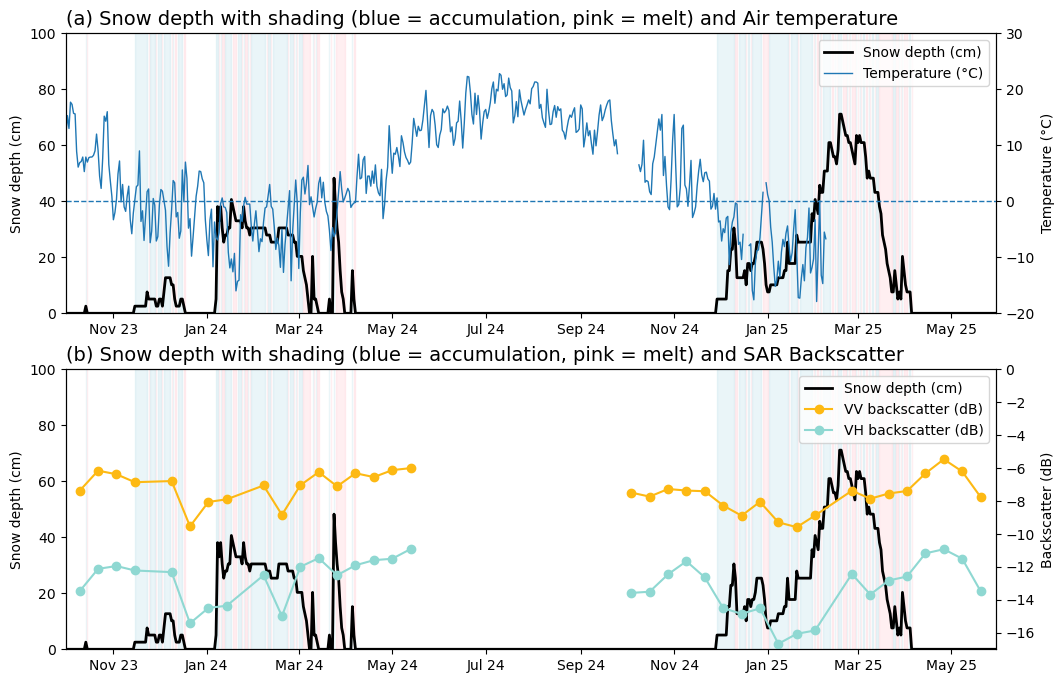

In [8]:
## Snow time series
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ---------------------------------------------------------
# (a) Snow depth + Temperature (dual axis)
# ---------------------------------------------------------
ax1 = axes[0]       # left axis
ax2 = ax1.twinx()   # right axis

# temperature
line_temp, = ax2.plot(df['Date'], df['TOBS.I-1 (degC) '],
                     color='#1f77b4', lw=1, label='Temperature (°C)')

ax2.axhline(0, color='#1f77b4', linestyle='--', linewidth=1)
ax2.set_ylim(-20, 30)

# snow depth
line_sd, = ax1.plot(df['Date'], df['snow_depth_cm'], 'k-', lw = 2, label = 'Snow depth (cm)')
ax1.set_ylim(0, 100)
ax1.set_xlim(datetime(2023, 10, 1), datetime(2025, 5, 30))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

# shading
acc = df['Stage'] == 'Accumulation'
melt = df['Stage'] == 'Melt'

ymax = ax1.get_ylim()[1]

ax1.fill_between(df['Date'], 0, ymax,
                 where=acc, color='lightblue', alpha=0.25, label = 'Accumulation')

ax1.fill_between(df['Date'], 0, ymax,
                 where=melt, color='pink', alpha=0.25, label = 'Melt')

# label
ax1.set_ylabel("Snow depth (cm)")
ax2.set_ylabel("Temperature (°C)")

# legend
ax1.legend(handles=[line_sd, line_temp])

# title
ax1.set_title("(a) Snow depth with shading (blue = accumulation, pink = melt) and Air temperature", loc = 'left', fontsize = 14)


# ---------------------------------------------------------
# (b) Snow depth + backscatter
# ---------------------------------------------------------
ax1 = axes[1]
ax2 = ax1.twinx()

# snow depth
line_sd, = ax1.plot(df['Date'], df['snow_depth_cm'], 'k-', lw = 2, label = 'Snow depth (cm)')
ax1.set_ylim(0, 100)
ax1.set_xlim(datetime(2023, 10, 1), datetime(2025, 5, 30))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

# shading
acc = df['Stage'] == 'Accumulation'
melt = df['Stage'] == 'Melt'

ymax = ax1.get_ylim()[1]

ax1.fill_between(df['Date'], 0, ymax,
                 where=acc, color='lightblue', alpha=0.25, label = 'Accumulation')

ax1.fill_between(df['Date'], 0, ymax,
                 where=melt, color='pink', alpha=0.25, label = 'Melt')


# backscatter
season1 = (df['Date'] >= datetime(2023,10,1)) & (df['Date'] <= datetime(2024,5,31))
season2 = (df['Date'] >= datetime(2024,10,1)) & (df['Date'] <= datetime(2025,5,31))

# VV
line_VV, = ax2.plot(df.loc[season1 & df['VV'].notna(), 'Date'],
          df.loc[season1 & df['VV'].notna(), 'VV'],
          'o-', color="#FDB913", label="VV backscatter (dB)")

ax2.plot(df.loc[season2 & df['VV'].notna(), 'Date'],
          df.loc[season2 & df['VV'].notna(), 'VV'],
          'o-', color="#FDB913", label="VV backscatter")

# VH
line_VH, = ax2.plot(df.loc[season1 & df['VH'].notna(), 'Date'],
          df.loc[season1 & df['VH'].notna(), 'VH'],
          'o-', color="#8FD8D2", label="VH backscatter (dB)")

ax2.plot(df.loc[season2 & df['VH'].notna(), 'Date'],
          df.loc[season2 & df['VH'].notna(), 'VH'],
          'o-', color="#8FD8D2", label="VH backscatter")

ax2.set_ylim(-17, 0)

# label
ax1.set_ylabel("Snow depth (cm)")
ax2.set_ylabel("Backscatter (dB)")

# legend
ax1.legend(handles=[line_sd, line_VV, line_VH])

# title
ax1.set_title("(b) Snow depth with shading (blue = accumulation, pink = melt) and SAR Backscatter", loc = 'left', fontsize = 14)


plt.show()

In order to specify the relationship between snow and sentinel-1 signal, snow depth, VV and VH backscatter are shown in Figure 1.  
Figure 1 summarizes the seasonal evolution of snow depth, temperature, and Sentinel‑1 backscatter at Hubbard Brook for two winters.  

(a) Show snow depth with air temperature and snow-stage shading    
Daily temperature were mostly below freezing in December~ March. In late March, temperature started to rise above the 0 degC.    
Snow depth increased throughout the winter during Jan and March, and reached a maximum ~70cm.  

(b) Show snow depth with VV and VH backscatter and the same stage shading    
VV and VH backscatter generally show relatively stable values during cold accumulation periods, when the snowpack is dry. During melt period, when liquid water appears in the snowpack, backscatter tends to change. Wet snow strongly attenuates C‑band SAR and reduces volume scattering from the snowpack.


# FIGURE 2: Box plots

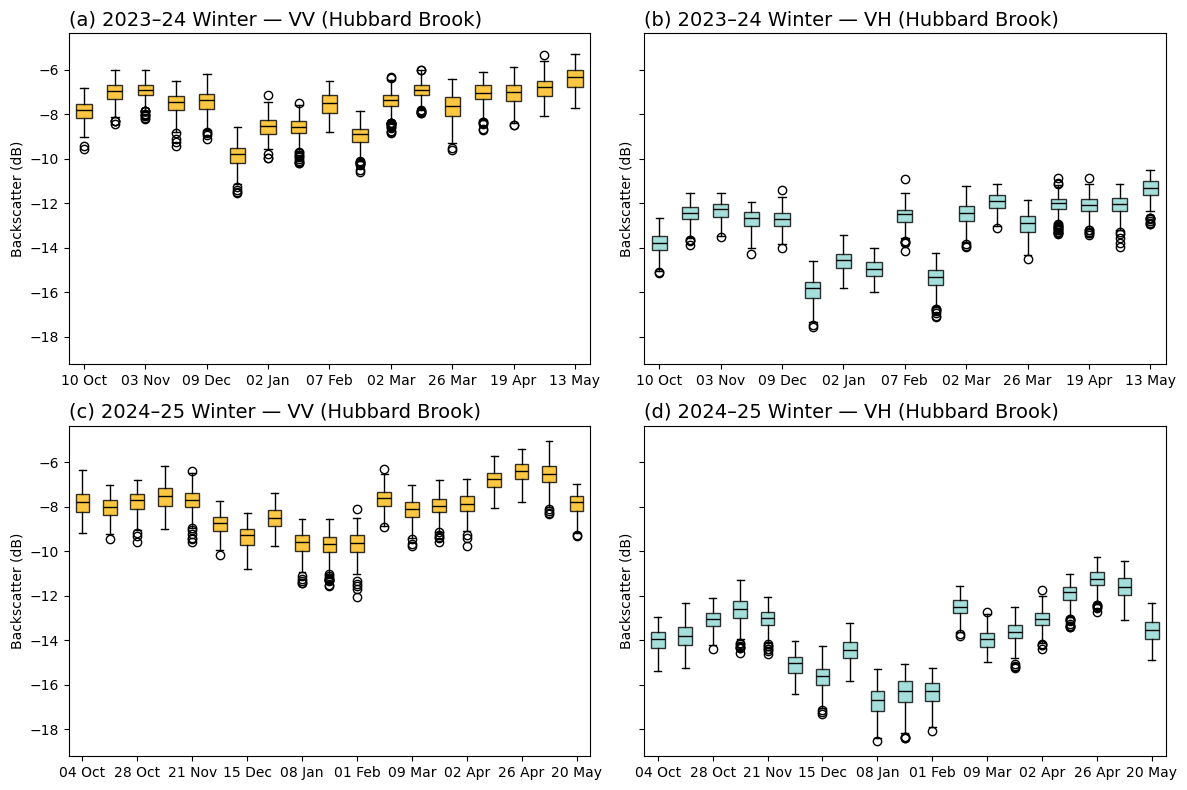

In [9]:
# Define winter periods
season1 = (df_VV_62.index >= "2023-10-01") & (df_VV_62.index <= "2024-05-31")
season2 = (df_VV_62.index >= "2024-10-01") & (df_VV_62.index <= "2025-05-31")

dates_s1 = df_VV_62.index[season1]
dates_s2 = df_VV_62.index[season2]

vv_s1 = [df_VV_62.loc[d].dropna().values for d in dates_s1]
vh_s1 = [df_VH_62.loc[d].dropna().values for d in dates_s1]
vv_s2 = [df_VV_62.loc[d].dropna().values for d in dates_s2]
vh_s2 = [df_VH_62.loc[d].dropna().values for d in dates_s2]

# figure
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)

titles = [
    "(a) 2023–24 Winter — VV (Hubbard Brook)",
    "(b) 2023–24 Winter — VH (Hubbard Brook)",
    "(c) 2024–25 Winter — VV (Hubbard Brook)",
    "(d) 2024–25 Winter — VH (Hubbard Brook)"
]
colors = ["#FDB913", "#8FD8D2", "#FDB913", "#8FD8D2"]

data_list = [vv_s1, vh_s1, vv_s2, vh_s2]
dates_list = [dates_s1, dates_s1, dates_s2, dates_s2]

# ---------------------------------------------------------
# Helper: Boxplot function
# ---------------------------------------------------------
def plot_boxes(ax, data, dates, title, color):
    x_pos = np.arange(len(dates))

    ax.boxplot(
        data,
        positions=x_pos,
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor=color, edgecolor="black", alpha=0.8),
        medianprops=dict(color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black")
    )

    ax.set_title(title, fontsize=14, loc='left')
    ax.set_ylabel("Backscatter (dB)")

    ax.set_xticks(x_pos[::2])
    ax.set_xticklabels([d.strftime("%d %b") for d in dates[::2]])

for ax, data, dates, title, color in zip(
        axes.flatten(), data_list, dates_list, titles, colors):
    plot_boxes(ax, data, dates, title, color)

plt.tight_layout()
plt.show()

This figure shows the evolution of VV and VH backscatter at Hubbard Brook over two winters. Overall, VV and VH show related but distinct responses to seasonal snow. 
In both winters, VV remains relatively high and pretty stable through much of the cold season.  
VH exhibits larger variability and clearer decreases during melt and transitional periods compared to VV.  


*Note  
In general, C‑band backscatter over snow‑covered terrain can include contributions from vegetation, the air–snow interface, volume scattering within the snowpack, and the snow–ground interface. As the snow becomes deeper and more structured, volume scattering typically increases.  
During melt, liquid water in the snowpack attenuates the ground and volume scattering components, leading to reduced C‑band backscatter.

# FIGURE 3: Maps

In [10]:
# Select polarization (VH)
polarization = "VH" # 
data_dir = vh_dir if polarization == "VH" else vv_dir

# Load file
files = sorted(list(data_dir.glob("*.tif"))) #list of GeoTIFF files
files = sorted(data_dir.glob("*.tif"))
if not files:
    raise FileNotFoundError(f"No .tif files ")
print(f"{len(files)} {polarization} images")

# Select polarization (VV)

polarization2 = "VV" # 
data_dir = vv_dir if polarization2 == "VV" else vh_dir

# Load file
files2 = sorted(list(data_dir.glob("*.tif"))) #list of GeoTIFF files
files2 = sorted(data_dir.glob("*.tif"))
if not files2:
    raise FileNotFoundError(f"No .tif files ")
print(f"{len(files2)} {polarization2} images")

36 VH images
36 VV images


VH backscatter

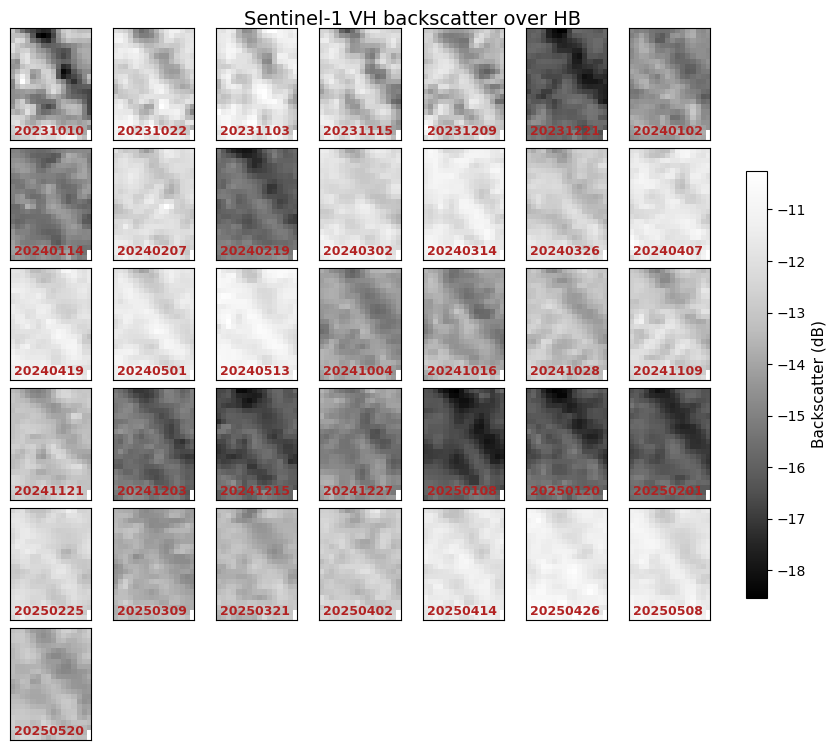

In [11]:
# Mapping sentinel-1 

n = len(files)
cols = 7
rows = int(np.ceil(n / cols))
figsize_per_tile = 1.2
fig_all, axes = plt.subplots(rows, cols,
                             figsize=(cols * figsize_per_tile, rows * figsize_per_tile),
                             constrained_layout=True)
axes = axes.flatten()

#initialize value to keep the minimum and maximum values across all images.
#Since dB values include negative numbers, set +/- infinite.
vmin, vmax = np.inf, -np.inf 

for i, f in enumerate(files): # give both the index (i) and the file path (f)
    with rasterio.open(f) as src: #open GeoTIFF using the rasterio library and automatically closes the file after reading
        sar = src.read(1).astype(float) # read 1st band and converts it to float (floats are needed for log10)
        sar[sar <= 0] = np.nan # 'sar' contains backscatter values
        sar_dB = 10 * np.log10(sar) # convert unit (desibel)
        extent = [ # defines the geographic information of the image (map coordinates).
            src.transform[2], #left (x_min)
            src.transform[2] + src.transform[0] * src.width, # move width * pixel size step to right (x_max) 
            src.transform[5] + src.transform[4] * src.height, # move height * pixel size step to bottom down (y_min)
            src.transform[5],# top (y_max)
        ]
    vmin = min(vmin, np.nanmin(sar_dB))
    vmax = max(vmax, np.nanmax(sar_dB))
    ax = axes[i]
    im = ax.imshow(sar_dB, extent=extent, origin="upper", cmap="Greys_r", vmin=vmin, vmax=vmax)
    

    date_str = f.stem.split("_")[2][:8] if len(f.stem.split("_")) > 2 else f.stem
    ax.text(0.05, 0.05, date_str, color="firebrick", fontsize=9, fontweight="bold", transform=ax.transAxes)
    ax.set_xticks([]); ax.set_yticks([])

# Turn off empty axes
for ax in axes[len(files):]:
    ax.axis("off")

# colorbar
cbar = fig_all.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
cbar.set_label("Backscatter (dB)", fontsize=11)

plt.suptitle(f"Sentinel-1 {polarization} backscatter over HB", fontsize=14, y=1.02)
plt.show()

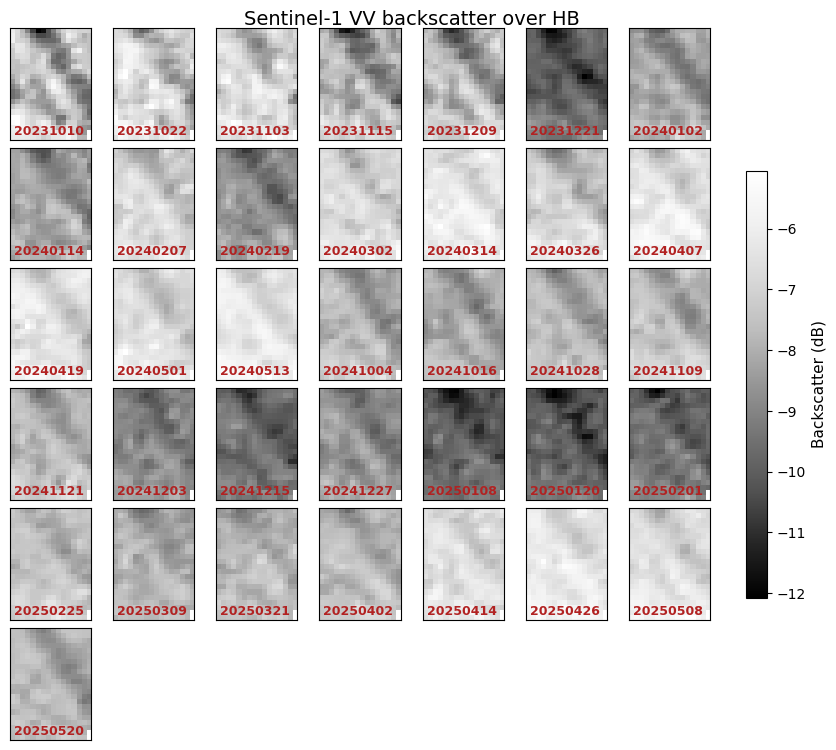

In [12]:
n = len(files2)
cols = 7
rows = int(np.ceil(n / cols))
figsize_per_tile = 1.2
fig_all, axes = plt.subplots(rows, cols,
                             figsize=(cols * figsize_per_tile, rows * figsize_per_tile),
                             constrained_layout=True)
axes = axes.flatten()

#initialize value to keep the minimum and maximum values across all images.
#Since dB values include negative numbers, set +/- infinite.
vmin, vmax = np.inf, -np.inf 

for i, f in enumerate(files2): # give both the index (i) and the file path (f)
    with rasterio.open(f) as src: #open GeoTIFF using the rasterio library and automatically closes the file after reading
        sar2 = src.read(1).astype(float) # read 1st band and converts it to float (floats are needed for log10)
        sar2[sar2 <= 0] = np.nan # 'sar' contains backscatter values
        sar_dB2 = 10 * np.log10(sar2) # convert unit (desibel)
        extent = [ # defines the geographic information of the image (map coordinates).
            src.transform[2], #left (x_min)
            src.transform[2] + src.transform[0] * src.width, # move width * pixel size step to right (x_max) 
            src.transform[5] + src.transform[4] * src.height, # move height * pixel size step to bottom down (y_min)
            src.transform[5],# top (y_max)
        ]
    vmin = min(vmin, np.nanmin(sar_dB2))
    vmax = max(vmax, np.nanmax(sar_dB2))
    ax = axes[i]
    im = ax.imshow(sar_dB2, extent=extent, origin="upper", cmap="Greys_r", vmin=vmin, vmax=vmax)
    

    date_str = f.stem.split("_")[2][:8] if len(f.stem.split("_")) > 2 else f.stem
    ax.text(0.05, 0.05, date_str, color="firebrick", fontsize=9, fontweight="bold", transform=ax.transAxes)
    ax.set_xticks([]); ax.set_yticks([])

# Turn off empty axes
for ax in axes[len(files2):]:
    ax.axis("off")

# colorbar
cbar = fig_all.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
cbar.set_label("Backscatter (dB)", fontsize=11)

plt.suptitle(f"Sentinel-1 {polarization2} backscatter over HB", fontsize=14, y=1.02)
plt.show()

![SAR](SAR.png)


Brighter pixels tend to correspond to exposed ridges, where surface and vegetation scattering are stronger. Darker pixels occur in concave or lower areas, which may be more sheltered. This indicates that, topography and forest structure play a major role in controlling the spatial pattern of backscatter. Notably, the spatial difference between ridges is much stronger in VH than in VV. This means that cross‑polarized backscatter is more sensitive to complex surface and canopy structure.

# FIGURE 4: Scatter plot 1 - Snow depth vs backscatter

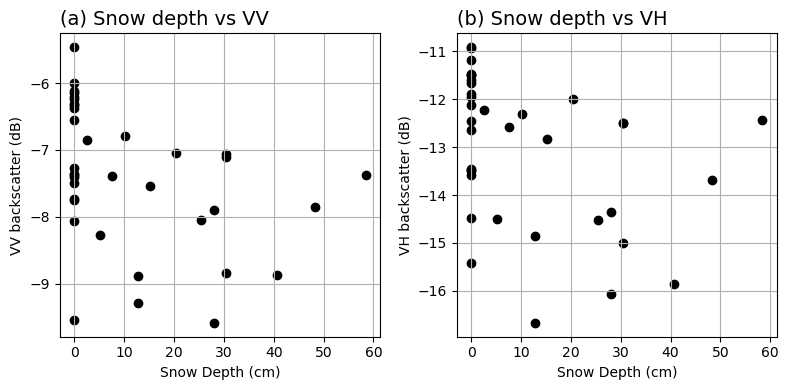

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

# === VV ===
ax = axes[0]
ax.scatter(df['snow_depth_cm'], df['VV'], color='black')
ax.set_title("(a) Snow depth vs VV", loc='left', fontsize=14)
ax.set_xlabel("Snow Depth (cm)")
ax.set_ylabel("VV backscatter (dB)")
ax.grid(True)

# === VH ===
ax = axes[1]
ax.scatter(df['snow_depth_cm'], df['VH'], color='black')
ax.set_title("(b) Snow depth vs VH", loc='left', fontsize=14)
ax.set_xlabel("Snow Depth (cm)")
ax.set_ylabel("VH backscatter (dB)")
ax.grid(True)

plt.tight_layout()
plt.show()

As we showed the map, C‑band backscatter is influenced by multiple factors (surface roughness, slope, and snow wetness). Therefore, simple  correlations between backscatter and snow depth can be weak, especially in shallow, forested snowpack.  
Therefore, the relationship should be analyzed in a categorical manner (e.g., divided by temperature).

# FIGURE 4: Scatter plot 2 - temperature threshold

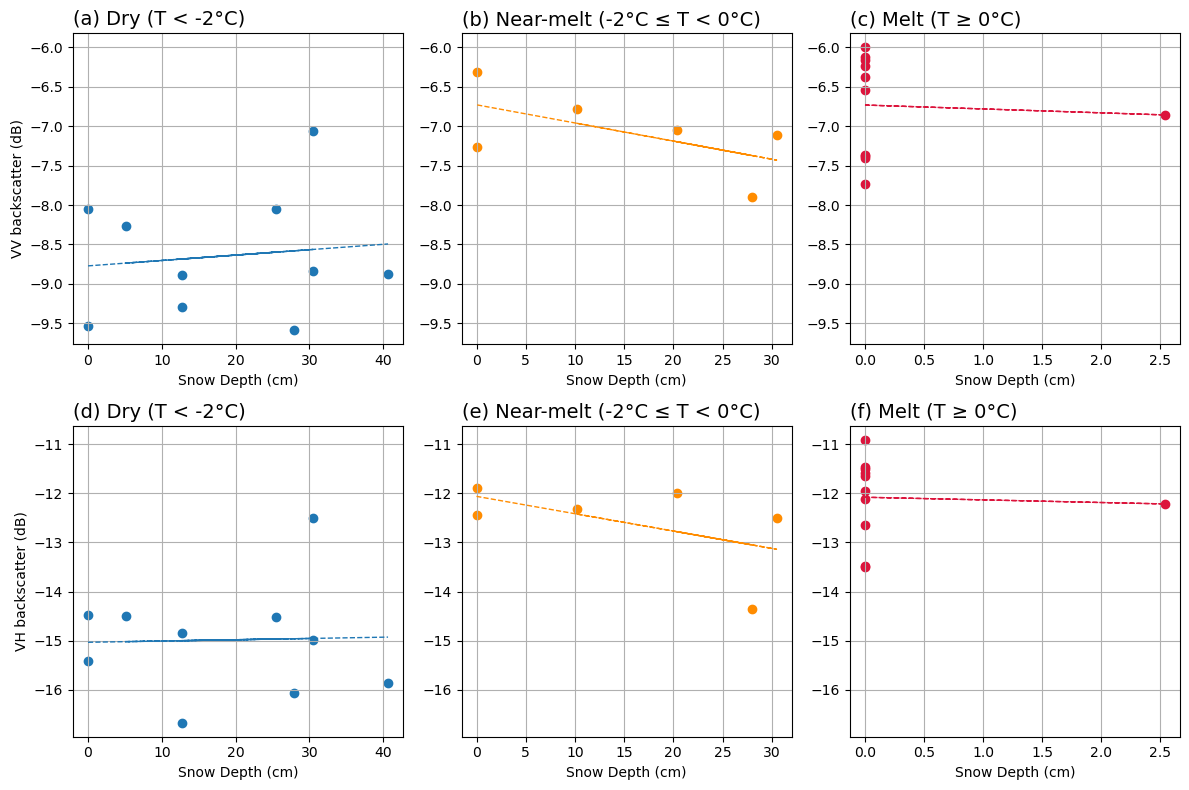

In [14]:
# 1) Dry / Near-melt / Melt
dry      = df['TOBS.I-1 (degC) '] < -2
nearmelt = (df['TOBS.I-1 (degC) '] >= -2) & (df['TOBS.I-1 (degC) '] < 0)
melt     = df['TOBS.I-1 (degC) '] >= 0

# 2) Scatter plot: Depth vs Backscatter
fig = plt.figure(figsize=(12, 8))

# -----------------------------
# VV row (share y between VV)
# -----------------------------
ax_vv1 = plt.subplot2grid((2,3), (0,0))
ax_vv2 = plt.subplot2grid((2,3), (0,1), sharey=ax_vv1)
ax_vv3 = plt.subplot2grid((2,3), (0,2), sharey=ax_vv1)

# -----------------------------
# VH row (share y between VH)
# -----------------------------
ax_vh1 = plt.subplot2grid((2,3), (1,0))
ax_vh2 = plt.subplot2grid((2,3), (1,1), sharey=ax_vh1)
ax_vh3 = plt.subplot2grid((2,3), (1,2), sharey=ax_vh1)


ax = ax_vv1
ax.scatter(df.loc[dry,'snow_depth_cm'], df.loc[dry,'VV'], color='#1f77b4')

sub = df.loc[dry, ['snow_depth_cm','VV']].dropna() # polyfit purpose
ax.plot(sub['snow_depth_cm'], 
        np.poly1d(np.polyfit(sub['snow_depth_cm'], sub['VV'], 1))(sub['snow_depth_cm']),
        '--', lw=1, color='#1f77b4')

ax.set_title("(a) Dry (T < -2°C)", fontsize=14, loc='left')
ax.set_xlabel("Snow Depth (cm)")
ax.set_ylabel("VV backscatter (dB)")
ax.grid(True)


ax = ax_vv2
ax.scatter(df.loc[nearmelt,'snow_depth_cm'], df.loc[nearmelt,'VV'], color='#FF8C00')

sub = df.loc[nearmelt, ['snow_depth_cm','VV']].dropna() # polyfit purpose
ax.plot(sub['snow_depth_cm'], 
        np.poly1d(np.polyfit(sub['snow_depth_cm'], sub['VV'], 1))(sub['snow_depth_cm']),
        '--', lw=1, color='#FF8C00')

ax.set_title("(b) Near-melt (-2°C ≤ T < 0°C)", fontsize=14, loc='left')
ax.set_xlabel("Snow Depth (cm)")
ax.grid(True)


ax = ax_vv3
ax.scatter(df.loc[melt,'snow_depth_cm'], df.loc[melt,'VV'], color='crimson')

sub = df.loc[melt, ['snow_depth_cm','VV']].dropna() # polyfit purpose
ax.plot(sub['snow_depth_cm'], 
        np.poly1d(np.polyfit(sub['snow_depth_cm'], sub['VV'], 1))(sub['snow_depth_cm']),
        '--', lw=1, color='crimson')

ax.set_title("(c) Melt (T ≥ 0°C)", fontsize=14, loc='left')
ax.set_xlabel("Snow Depth (cm)")
ax.grid(True)


ax = ax_vh1
ax.scatter(df.loc[dry,'snow_depth_cm'], df.loc[dry,'VH'], color='#1f77b4')

sub = df.loc[dry, ['snow_depth_cm','VH']].dropna() # polyfit purpose
ax.plot(sub['snow_depth_cm'], 
        np.poly1d(np.polyfit(sub['snow_depth_cm'], sub['VH'], 1))(sub['snow_depth_cm']),
        '--', lw=1, color='#1f77b4')

ax.set_title("(d) Dry (T < -2°C)", fontsize=14, loc='left')
ax.set_xlabel("Snow Depth (cm)")
ax.set_ylabel("VH backscatter (dB)")
ax.grid(True)


ax = ax_vh2
ax.scatter(df.loc[nearmelt,'snow_depth_cm'], df.loc[nearmelt,'VH'], color='#FF8C00')

sub = df.loc[nearmelt, ['snow_depth_cm','VH']].dropna() # polyfit purpose
ax.plot(sub['snow_depth_cm'], 
        np.poly1d(np.polyfit(sub['snow_depth_cm'], sub['VH'], 1))(sub['snow_depth_cm']),
        '--', lw=1, color='#FF8C00')

ax.set_title("(e) Near-melt (-2°C ≤ T < 0°C)", fontsize=14, loc='left')
ax.set_xlabel("Snow Depth (cm)")
ax.grid(True)


ax = ax_vh3
ax.scatter(df.loc[melt,'snow_depth_cm'], df.loc[melt,'VH'], color='crimson')

sub = df.loc[melt, ['snow_depth_cm','VH']].dropna() # polyfit purpose
ax.plot(sub['snow_depth_cm'], 
        np.poly1d(np.polyfit(sub['snow_depth_cm'], sub['VH'], 1))(sub['snow_depth_cm']),
        '--', lw=1, color='crimson')

ax.set_title("(f) Melt (T ≥ 0°C)", fontsize=14, loc='left')
ax.set_xlabel("Snow Depth (cm)")
ax.grid(True)


plt.tight_layout()
plt.show()

When divided by temperature (assuming dry snow when temperature is below -2 deg.C / melting condition when temperature is above -2 deg.C), there appears a positive and negative relationships, especially when the snow is wet (panels b and e).
 - when the snow is dry, scattering increases as snow accumulates -> backscatter increases (more snow and low temperature → more scattering)
 - when the snow is wet, near the melting point, the relationship becomes negative, especially for wet and transitional snow.

# FIGURE 5: Scatter plot 3 - polarization diff (VV minus VH) vs temperature

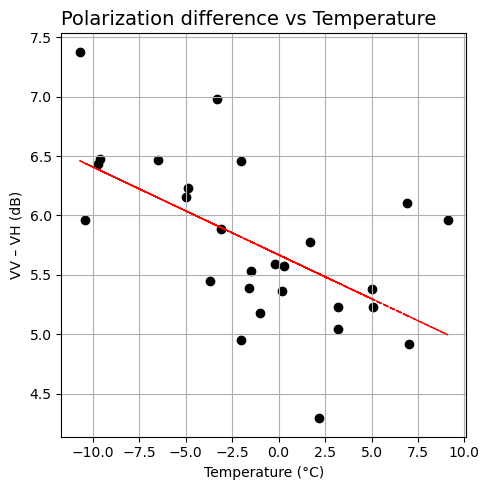

In [15]:
df['VV_VH_diff'] = df['VV'] - df['VH']

fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

ax.scatter(df['TOBS.I-1 (degC) '], df['VV_VH_diff'], color='black')

# polyfit for trend
sub = df[['TOBS.I-1 (degC) ', 'VV_VH_diff']].dropna()
coef = np.polyfit(sub['TOBS.I-1 (degC) '], sub['VV_VH_diff'], 1)
ax.plot(sub['TOBS.I-1 (degC) '], np.poly1d(coef)(sub['TOBS.I-1 (degC) ']),'r--', lw=1)

ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("VV – VH (dB)")
ax.set_title("Polarization difference vs Temperature", loc='left', fontsize=14)
ax.grid(True)

plt.tight_layout()
plt.show()

This scatterplot shows how the polarization difference varies with air temperature.  
The polarization difference (VV - VH) decreases with increasing temperature, as VV backscatter weakens more rapidly than VH under wet snow conditions due to stronger attenuation by liquid water.  
At cold temperatures the VV–VH difference is large, but as temperature approaches and exceeds 0 degC the difference shrinks. This suggests that warming and melt conditions tend to reduce the difference between co- and cross‑polarized backscatter, led by increased liquid water and structural changes in the snowpack and canopy.

# Conclusion
In this study, I focus on a shallow, transient snowpack at Hubbard Brook. In such conditions, Sentinel‑1 C‑band backscatter is not controlled by snow depth alone, but by a combination of temperature, snow phase, and surface characteristics. These results suggest that, for shallow snowpacks, it is useful to analyze backscatter in a regime‑based way, for example by separating data by temperature and snow stage, rather than assuming a single relationship between backscatter and snow depth.